## Load packages and data


In [1]:
# General utilities
import os
import numpy as np
import pickle
import random

# Image processing
from PIL import Image
import cv2

# Machine learning and neural network (Keras/TensorFlow)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam
from keras import backend as K

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Setting the seed for Python's built-in random module
random.seed(42)

# Setting the seed for NumPy's random number generation
np.random.seed(42)

# Setting the seed for TensorFlow's random number generation
tf.random.set_seed(42)

# Optional: control the determinism of operations in TensorFlow 2.x
# Note: This might impact performance (for TensorFlow 2.x)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/COMP642-project/PlantVillage" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._f2cfc53d-a165-47d5-a9ac-6877e52a97b6___GCREC_Bact.Sp 3804.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._4c24021e-90e2-4b84-89c2-c904dc8bb0b4___GCREC_Bact.Sp 5706.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/__MACOSX/PlantVillage/Tomato_Bacterial_spot/._9be85690-9fdb-4ddd-b007-686bc4074786___GCREC_Bact.Sp 5780.JPG  
  inflating: /content/dataset/PlantVillage/Tomato_Bacterial_spot/0b233197-cd35-4031-80c2-610e7e3a046b___GCREC_Bact.Sp 6095.JPG  
  inflating: 

## Data Pre-processing

In [5]:
EPOCHS = 30
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((75, 75))
image_size = 0
directory_root = '../content/dataset/PlantVillage'
width=75
height=75
depth=3

In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
directory_root = '/content/dataset/PlantVillage'
image_list, label_list = [], []

for root, dirs, files in os.walk(directory_root):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".JPG"):
            image_path = os.path.join(root, file)
            image_list.append(convert_image_to_array(image_path))
            label_list.append(root.split("/")[-1])


print(f"Loaded images: {len(image_list)}")


Loaded images: 16010


In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [12]:
print(label_binarizer.classes_)

['Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)


[INFO] Spliting data to train, test


## NN

In [11]:
# Assuming height, width, depth, and n_classes are defined
input_shape = (height, width, depth)
if K.image_data_format() == "channels_first":
    input_shape = (depth, height, width)

mlp_model = Sequential()

# Flatten the input image
mlp_model.add(Flatten(input_shape=input_shape))

# First hidden layer
mlp_model.add(Dense(1024))  # Increasing the number of neurons
mlp_model.add(Activation("relu"))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))  # Slightly increasing dropout rate

# Second hidden layer
mlp_model.add(Dense(512))
mlp_model.add(Activation("relu"))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

# Third hidden layer
mlp_model.add(Dense(512))  # Adding another layer with 512 neurons
mlp_model.add(Activation("relu"))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.3))

# Fourth hidden layer
mlp_model.add(Dense(256))
mlp_model.add(Activation("relu"))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.25))

# Fifth hidden layer
mlp_model.add(Dense(128))  # Adding another layer with 128 neurons
mlp_model.add(Activation("relu"))
mlp_model.add(BatchNormalization())
mlp_model.add(Dropout(0.2))

# Output layer
mlp_model.add(Dense(n_classes))
mlp_model.add(Activation("softmax"))

# Compile the model
mlp_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=1000,
    decay_rate=0.9)

opt = Adam(learning_rate=lr_schedule)

mlp_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Training MLP network...")

[INFO] Training MLP network...


In [14]:
mlp_history = mlp_model.fit(
    x_train, y_train,
    batch_size=BS,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1
)


Epoch 1/100
400/400 [==============================] - 14s 18ms/step - loss: 0.3965 - accuracy: 0.4135 - val_loss: 0.2016 - val_accuracy: 0.5684
Epoch 2/100
400/400 [==============================] - 5s 13ms/step - loss: 0.1951 - accuracy: 0.6021 - val_loss: 0.2051 - val_accuracy: 0.5440
Epoch 3/100
400/400 [==============================] - 5s 13ms/step - loss: 0.1635 - accuracy: 0.6727 - val_loss: 0.2388 - val_accuracy: 0.4428
Epoch 4/100
400/400 [==============================] - 6s 14ms/step - loss: 0.1497 - accuracy: 0.7035 - val_loss: 0.3146 - val_accuracy: 0.3851
Epoch 5/100
400/400 [==============================] - 5s 13ms/step - loss: 0.1460 - accuracy: 0.7084 - val_loss: 0.3846 - val_accuracy: 0.4157
Epoch 6/100
400/400 [==============================] - 6s 15ms/step - loss: 0.1407 - accuracy: 0.7173 - val_loss: 0.3457 - val_accuracy: 0.4094
Epoch 7/100
400/400 [==============================] - 5s 13ms/step - loss: 0.1370 - accuracy: 0.7239 - val_loss: 0.2621 - val_accuracy

In [20]:
def plot_graph(train_acc, val_acc, train_loss, val_loss, model):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
    plt.title(f'{model} Training and Testing Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Testing loss')
    plt.title(f'{model} Training and Testing Loss')
    plt.legend()
    plt.show()

def get_report(y_true, y_pred):
    # Generate the classification report
    clr = classification_report(y_true, y_pred, target_names=label_binarizer.classes_, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=label_binarizer.classes_))

    # Overall accuracy
    overall_accuracy = accuracy_score(y_true, y_pred)

    # Extract overall precision, recall, f1-score from the classification report
    overall_precision = clr['weighted avg']['precision']
    overall_recall = clr['weighted avg']['recall']
    overall_f1 = clr['weighted avg']['f1-score']

    print(f'Overall Accuracy: {overall_accuracy:.2f}')
    print(f'Overall Precision: {overall_precision:.2f}')
    print(f'Overall Recall: {overall_recall:.2f}')
    print(f'Overall F1-Score: {overall_f1:.2f}')

    # Confusion Matrix
    cm = tf.math.confusion_matrix(y_true, y_pred).numpy()
    print("Confusion Matrix:\n", cm)

    # Calculate class-specific accuracy
    cm_diag = np.diag(cm)
    cm_sum = np.sum(cm, axis=1)
    class_accuracy = cm_diag / cm_sum
    class_accuracy_dict = {k: round(v, 2) for k, v in zip(label_binarizer.classes_, class_accuracy)}
    cm_ratio = cm / cm_sum.astype(float)
    print('Class Accuracy:')
    for k, v in class_accuracy_dict.items():
        print(f"{k}: {v}")

def plot_confusion_matrix(y_true, y_pred, classes, normalize='true', title=None, cmap=plt.cm.Blues,
                          figsize=(10, 8), font_size=8):
    matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    plt.figure(figsize=figsize)
    display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=np.arange(classes))
    display.plot(cmap=cmap, values_format='.3f')

    plt.title('Normalized confusion matrix ({})'.format(title), fontsize=font_size+2)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xlabel('Predicted label', fontsize=font_size)
    plt.ylabel('True label', fontsize=font_size)

    # Set the font size of the annotations
    for text in display.text_.flatten():
        text.set_fontsize(font_size)

    # Uncomment the line below to save the figure if needed
    # plt.savefig('./figures/confusion_matrix_' + title + '.png')

    plt.show()

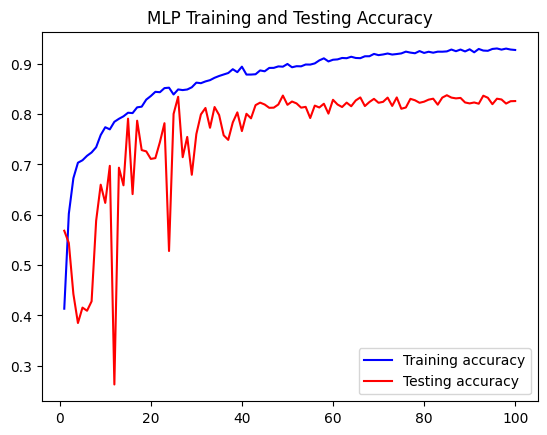

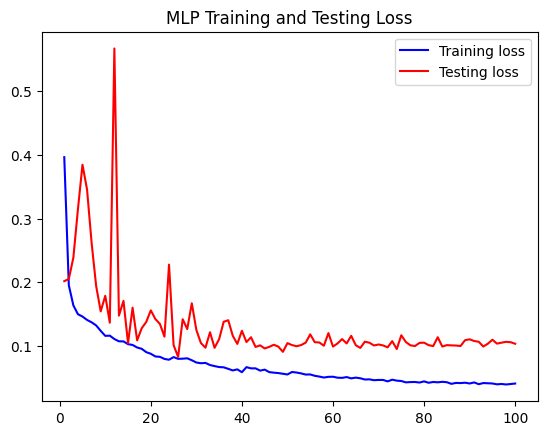

101/101 [==============================] - 1s 3ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.77      0.93      0.85       404
                        Tomato_Early_blight       0.65      0.48      0.55       187
                         Tomato_Late_blight       0.86      0.75      0.80       398
                           Tomato_Leaf_Mold       0.83      0.76      0.79       201
                  Tomato_Septoria_leaf_spot       0.87      0.84      0.85       355
Tomato_Spider_mites_Two_spotted_spider_mite       0.77      0.82      0.79       319
                        Tomato__Target_Spot       0.70      0.77      0.74       269
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.91      0.91      0.91       687
                Tomato__Tomato_mosaic_virus       0.83      0.94      0.88        62
                             Tomato_healthy       0.89      0.86      0.87       320

        

<Figure size 1000x800 with 0 Axes>

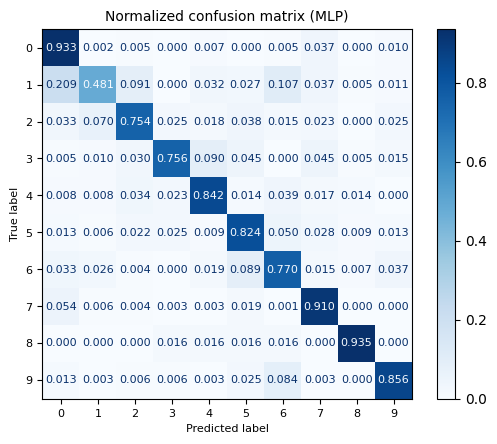

In [21]:
plot_graph(mlp_history.history['accuracy'], mlp_history.history['val_accuracy'], mlp_history.history['loss'], mlp_history.history['val_loss'], 'MLP')
y_pred = np.argmax(mlp_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
get_report(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, 10, 'true', 'MLP')

## CNN

In [34]:
cnn_model = Sequential()
inputShape = (height, width, depth)
chanDim = -1

# Adjust input shape if using channels_first data format
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

# Define 4 blocks of Convolutional layers
filters = 32
for i in range(5):  # 5 Conv2D layers per block, for 5 blocks
    for j in range(5):
      if i==0 and j==0:
        cnn_model.add(Conv2D(filters, (3, 3), padding="same", input_shape=inputShape if i == 0 and j == 0 else None))
        cnn_model.add(Activation("relu"))
        cnn_model.add(BatchNormalization(axis=chanDim))
      else:
        cnn_model.add(Conv2D(filters, (3, 3), padding="same", input_shape=inputShape))
        cnn_model.add(Activation("relu"))
        cnn_model.add(BatchNormalization(axis=chanDim))

    # Add MaxPooling2D and Dropout at the end of each block
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))
    filters *= 2

# Flatten and Dense Layers
cnn_model.add(Flatten())
cnn_model.add(Dense(1024))
cnn_model.add(Activation("relu"))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(n_classes))
cnn_model.add(Activation("softmax"))


# Learning Rate Scheduler and Optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=1000,
    decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

# Compile the model
cnn_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Training cnn_network...")

[INFO] Training cnn_network...


In [35]:
import time

start_time = time.time()

cnn_history = cnn_model.fit(
    x_train, y_train,
    batch_size=BS,
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1
)

end_time = time.time()
total_time = end_time - start_time
print(f'Total training time: {total_time//60:.0f}m {total_time%60:.0f}s')

Epoch 1/50
400/400 [==============================] - 61s 117ms/step - loss: 0.2972 - accuracy: 0.5025 - val_loss: 0.5303 - val_accuracy: 0.1736
Epoch 2/50
400/400 [==============================] - 44s 111ms/step - loss: 0.1374 - accuracy: 0.7366 - val_loss: 0.2040 - val_accuracy: 0.6683
Epoch 3/50
400/400 [==============================] - 45s 113ms/step - loss: 0.1143 - accuracy: 0.7858 - val_loss: 0.1725 - val_accuracy: 0.7214
Epoch 4/50
400/400 [==============================] - 45s 112ms/step - loss: 0.0923 - accuracy: 0.8310 - val_loss: 0.1075 - val_accuracy: 0.8042
Epoch 5/50
400/400 [==============================] - 45s 112ms/step - loss: 0.0848 - accuracy: 0.8482 - val_loss: 0.3428 - val_accuracy: 0.5231
Epoch 6/50
400/400 [==============================] - 45s 113ms/step - loss: 0.1514 - accuracy: 0.7076 - val_loss: 0.1648 - val_accuracy: 0.6993
Epoch 7/50
400/400 [==============================] - 45s 113ms/step - loss: 0.0991 - accuracy: 0.8121 - val_loss: 0.1369 - val_ac

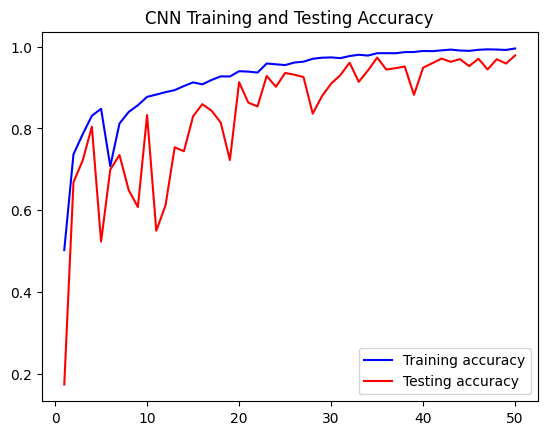

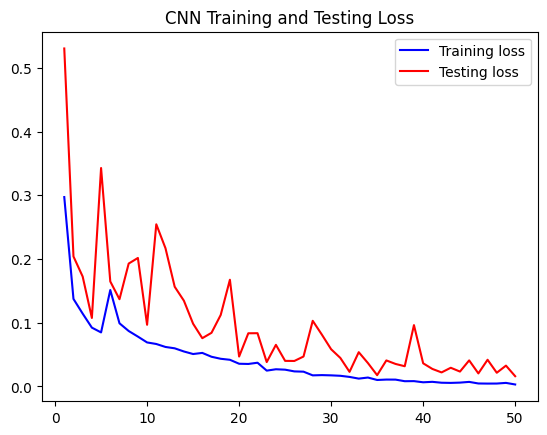

101/101 [==============================] - 3s 22ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       1.00      0.99      0.99       404
                        Tomato_Early_blight       0.94      0.91      0.92       187
                         Tomato_Late_blight       0.96      0.98      0.97       398
                           Tomato_Leaf_Mold       0.97      0.99      0.98       201
                  Tomato_Septoria_leaf_spot       0.98      0.97      0.97       355
Tomato_Spider_mites_Two_spotted_spider_mite       0.97      0.97      0.97       319
                        Tomato__Target_Spot       0.94      0.95      0.95       269
      Tomato__Tomato_YellowLeaf__Curl_Virus       1.00      0.99      1.00       687
                Tomato__Tomato_mosaic_virus       1.00      1.00      1.00        62
                             Tomato_healthy       0.99      1.00      1.00       320

       

<Figure size 1000x800 with 0 Axes>

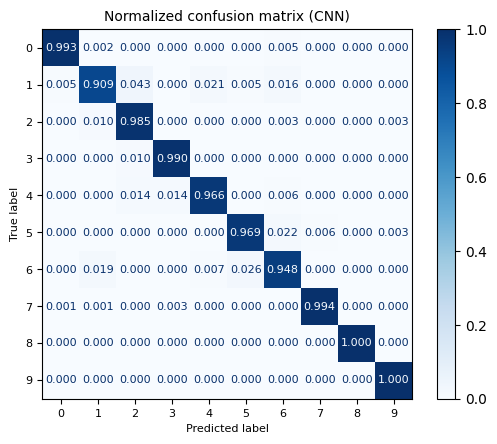

In [36]:
plot_graph(cnn_history.history['accuracy'], cnn_history.history['val_accuracy'], cnn_history.history['loss'], cnn_history.history['val_loss'], 'CNN')
y_pred = np.argmax(cnn_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
get_report(y_true, y_pred)
plot_confusion_matrix(y_true, y_pred, 10, 'true', 'CNN')